In [123]:
import healpy as hp
import numpy as np
import matplotlib as mpl
import matplotlib.image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from matplotlib import colors
from matplotlib import lines
from matplotlib.image import NonUniformImage
import astropy.io
from astropy.io import fits
from astropy import units as u
from astropy.units import cds
from astropy import constants as const
import random
import scipy
import scipy.integrate as integrate
from scipy import stats

In [2]:
#imports all the important maps that we'll use throughout the notebook

m = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1)    #reads mean amplitude primary map
nu_p = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1) #reads mean peak freqeuncy primary map
n = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2)    #same secondary map
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")                    #opens map header for frequency template
data = hdu[3].data                                                              #takes array from hdu[3]
nu_sd = np.array([i[0] for i in data])                                          #creates an array of template frequency
f = np.array([i[1] for i in data])                                              #creates an array of spdust2 spectrum
h = hp.read_map('mom0_-90_90_1024.hpx.fits')                                    #reads map of HI column denisty
nh = hp.pixelfunc.ud_grade(h, 256)                                              #degrades to NPIX = 256
CNM = hp.read_map('fcnm_hi4pi_hpx.fits')                                        #reads map of CNM fraction
f_CNM = hp.ud_grade(CNM, 256)                                                   #degrades to NPIX = 256

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [3]:
def I(A1, A2, nu_p1, nu_sd, f, nu):
    ''' Calculate a specific intensity curve for a pixel at either a range or a specific value of nu. First three args
        should be either all floats or all arrays; if arrays, nu should be float, otherwise nu can be either.
        
        Input:  A1: float or array, amplitude from primary map
                A2: float or array, amplitude from secondary map
                nu_p1: float or array, peak frequency from primary map
                nu_sd: array, template frequency
                f: array, template frequency 
                nu: float or array, range of frequencies over which to evaluate the function
        
        Return: array of shape [1,n] (if first three args are floats); 
                  --> values of specific intensity in MJy/sr for each of the n discrete values of nu
                array of shape [n,1] (if first three args are arrays);
                  --> values of specific intensity in MJy/sr at a given nu for each pixel of a map
    '''
    nu_p0 = 30. 
    nu_p2 = 33.35 #sets frequency peak for all secondary pixels
    nu_01 = 22.8 #sets reference freq for primary pixels
    nu_02 = 41.0 #sets reference freq for secondary pixels
    nu_1 = nu_01*(nu_p0/nu_p1) #sets the value nu1 for f_sd1
    nu_2 = nu_02*(nu_p0/nu_p2) #same for 2
    nu_fsd1 = nu*(nu_p0/nu_p1)
    nu_fsd2 = nu*(nu_p0/nu_p2)
    
    f_sd1 = np.interp(nu_1, nu_sd, f) #interpolates nu_sd and f to create f_sd1 at nu1
    f_sd2 = np.interp(nu_2, nu_sd, f) #same for 2
    f_nu1 = np.interp(nu_fsd1, nu_sd, f) #same for general nu
    f_nu2 = np.interp(nu_fsd2, nu_sd, f) #same for general nu
    
    I_1 = A1*((nu_01/nu)**2)*(f_nu1/f_sd1) #component from primary 
    I_2 = A2*((nu_02/nu)**2)*(f_nu2/f_sd2) #component from secondary
    m_K1 = I_1*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #adds units to primary
    m_K2 = I_2*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #same for secondary
    m_J1 = m_K1.to(cds.MJy/cds.sr)
    m_J2 = m_K2.to(cds.MJy/cds.sr)
    m_J = m_J1 + m_J2
    return m_J * cds.sr/cds.MJy #gets rid of units for plotting purposes

In [62]:
def finite_fCNM(i,t):
    '''Limits our work to just pixels where fCNM is a valid value (i.e. non-negative and finite)
       
       Input:
        i: map
        t: array of sample pixels
        
       Return:
        Array of the sample pixels of the map for which f_CNM is both finite and above .0128'''
    
    l = []
    for a in t:
        if np.isfinite(f_CNM[a]) == 1 and f_CNM[a] > 0.02:
            l.append(i[a])
    return np.array(l)

t = np.random.choice(np.arange(len(f_CNM)), 100000, replace=False)

a1 = finite_fCNM(m,t)
a2 = finite_fCNM(n,t)
nup1 = finite_fCNM(nu_p,t)
fCNM = finite_fCNM(f_CNM,t)
N_HI = finite_fCNM(nh,t)

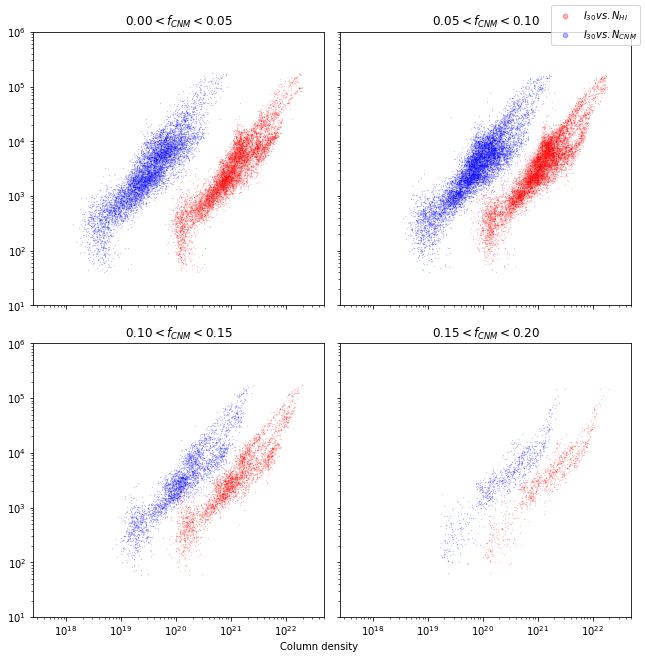

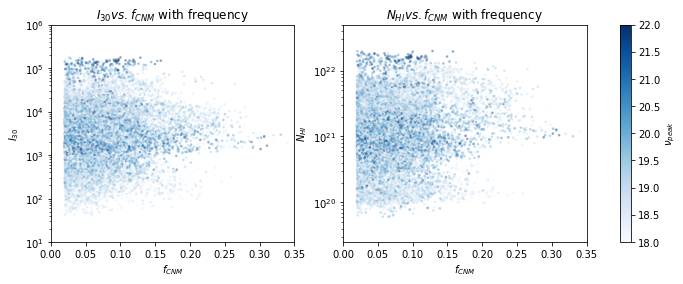

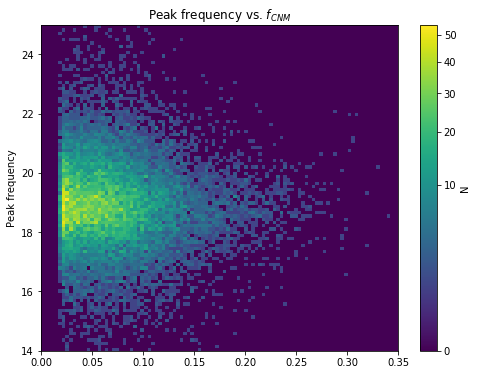

In [142]:
N_CNM = fCNM * N_HI

I30 = I(a1, a2, nup1, nu_sd, f, 20)

def IFN_bins(lo, hi):
    Ibin = I30[(fCNM > lo) & (fCNM <= hi)]
    Fbin = fCNM[(fCNM > lo) & (fCNM <= hi)]
    NHbin = N_HI[(fCNM > lo) & (fCNM <= hi)]
    NCbin = N_CNM[(fCNM > lo) & (fCNM <= hi)]
    nupbin = nup1[(fCNM > lo) & (fCNM <= hi)]
    return Ibin, Fbin, NHbin, NCbin, nupbin

I_bin0, F_bin0, NH_bin0, NCNM_bin0, nup_bin0 = IFN_bins(0.00, 0.05)
I_bin1, F_bin1, NH_bin1, NCNM_bin1, nup_bin1 = IFN_bins(0.05, 0.10)
I_bin2, F_bin2, NH_bin2, NCNM_bin2, nup_bin2 = IFN_bins(0.10, 0.15)
I_bin3, F_bin3, NH_bin3, NCNM_bin3, nup_bin3 = IFN_bins(0.15, 0.20)

fig, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(9,9))

a = ax[0,0].scatter(NH_bin0, I_bin0, s=.1, alpha=.3, c='r')
z = ax[0,0].scatter(NCNM_bin0, I_bin0, s=.1, alpha=.3, c='b')
ax[0,0].set_xlim(2.5e17, 5e22)
ax[0,0].set_ylim(10, 1e6)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_title(r'$0.00 < f_{CNM} < 0.05$')

b = ax[0,1].scatter(NH_bin1, I_bin1, s=.1, alpha=.3, c='r')
ax[0,1].scatter(NCNM_bin1, I_bin1, s=.1, alpha=.3, c='b')
ax[0,1].set_xlim(2.5e17, 5e22)
ax[0,1].set_ylim(10, 1e6)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_title(r'$0.05 < f_{CNM} < 0.10$')

c = ax[1,0].scatter(NH_bin2, I_bin2, s=.1, alpha=.3, c='r')
ax[1,0].scatter(NCNM_bin2, I_bin2, s=.1, alpha=.3, c='b')
ax[1,0].set_xlim(2.5e17, 5e22)
ax[1,0].set_ylim(10, 1e6)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_title(r'$0.10 < f_{CNM} < 0.15$')

d = ax[1,1].scatter(NH_bin3, I_bin3, s=.1, alpha=.3, c='r')
ax[1,1].scatter(NCNM_bin3, I_bin3, s=.1, alpha=.3, c='b')
ax[1,1].set_xlim(2.5e17, 5e22)
ax[1,1].set_ylim(10, 1e6)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_title(r'$0.15 < f_{CNM} < 0.20$')


fig.text(0.5, 0, 'Column density', ha='center')
plt.figlegend((a,z), (r'$I_{30} vs. N_{HI}$', r'$I_{30} vs. N_{CNM}$'), markerscale=15)
fig.tight_layout(pad=1.2)

fig1, ax1 = plt.subplots(1,2, figsize=(12,4))
for axis in ax1.flat:
    image = axis.imshow(np.random.random((10,10)), cmap='Blues', vmin=18, vmax=22)
    
cbar1 = fig1.colorbar(image, ax=ax1.ravel().tolist())
cbar1.set_label(r'$\nu_{peak}$')

ax1[0].scatter(fCNM, I30, s=3, alpha=.3, c=nup1, cmap='Blues', vmin=18, vmax=22)
ax1[0].set_xlim(0, 0.35)
ax1[0].set_ylim(10, 1e6)
ax1[0].set_xlabel(r'$f_{CNM}$')
ax1[0].set_ylabel(r'$I_{30}$')
ax1[0].set_yscale('log')
ax1[0].set_title(r'$I_{30} vs. f_{CNM}$' + ' with frequency')

ax1[1].scatter(fCNM, N_HI, s=3, alpha=.3, c=nup1, cmap='Blues', vmin=18, vmax=22)
ax1[1].set_ylim(2.5e19, 5e22)
ax1[1].set_xlim(0, .35)
ax1[1].set_xlabel(r'$f_{CNM}$')
ax1[1].set_ylabel(r'$N_{HI}$')
ax1[1].set_yscale('log')
ax1[1].set_title(r'$N_{HI} vs. f_{CNM}$' + ' with frequency')

fig2, ax2 = plt.subplots(figsize=(8,6))
g = ax2.hist2d(fCNM, nup1, bins=100, range=[[0, .35], [14, 25]], norm=colors.PowerNorm(.4))
ax2.set_ylabel('Peak frequency')
ax2.set_title('Peak frequency vs. ' + r'$f_{CNM}$')
cbar2 = fig2.colorbar(g[3])
cbar2.set_label('N')

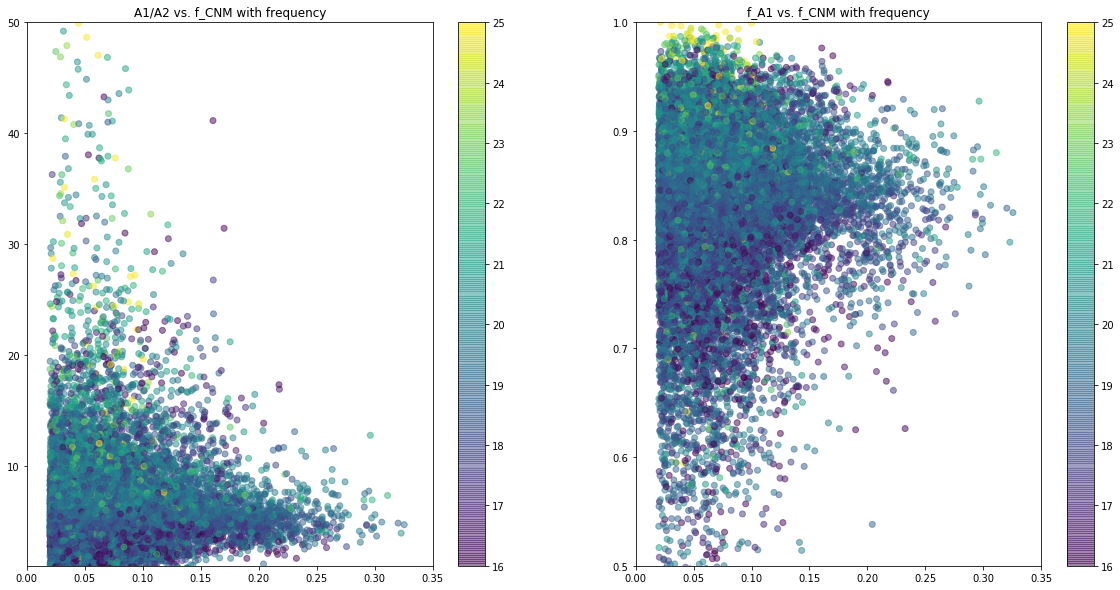

In [47]:
r = a1/a2
fa1 = a1/(a1+a2)
fa2 = a2/(a1+a2)

fig, ax = plt.subplots(1,2, figsize=(20,10))

#plots ratio of two amplitued vs. f_CNM
a = ax[0].scatter(fCNM, r, alpha=.5, c=nup1, vmin=16, vmax=25)
ax[0].set_ylim(1,50)
ax[0].set_xlim(0, .35)
ax[0].set_title('A1/A2 vs. f_CNM with frequency')
fig.colorbar(a, ax=ax[0])

#plots fraction of total amplitude included in primary map vs. f_CNM
b = ax[1].scatter(fCNM, fa1, alpha=.5, c=nup1, vmin=16, vmax=25)
ax[1].set_ylim(.5,1)
ax[1].set_xlim(0,.35)
ax[1].set_title('f_A1 vs. f_CNM with frequency')
fig.colorbar(b, ax=ax[1])

In [7]:
def plot_bin(frequencies, med, pos, neg, col):
    ''' Plots a median line and standard deviation region
       
        Input:
          frequencies: array or float; range of nu to be plotted
          med: array; median values at each nu
          pos: array; values at each nu of median + one standard deviation
          neg: array; values at each nu of median - one standard deviation
          col: list; color with which to plot the bin
          
        Returns: plot
    '''
    plt.plot(frequencies, med, color=col)
    plt.fill_between(frequencies, pos, neg, color=col, alpha=.5)
    return

Text(0, 0.5, 'Specific Intensity (MJy/sr)')

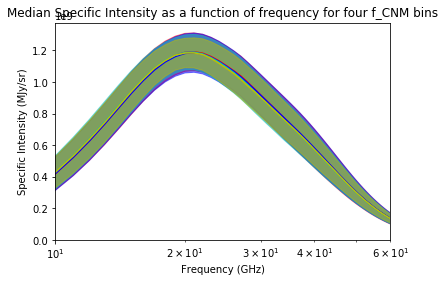

In [74]:
# Takes a different approach to the same task, creating a map of I(nu) at
# each integer nu, binning pixels from these maps by f_CNM, and plotting
# median SEDs with standard deviations for each bin.
nu = np.linspace(1, 100, 100)                                     #creates a range of frequency values, from 1 to 60 GHz

Im0, Im1, Im2, Im3 = (np.zeros(len(nu)) for i in range(4))      #creates four empty bins
Is0, Is1, Is2, Is3 = (np.zeros(len(nu)) for i in range(4)) 

low0, low1, low2, low3 = 0, 0.05, 0.10, 0.15
high0, high1, high2, high3 = 0.05, 0.10, 0.15, 0.20

I_normto = I(a1, a2, nup1, nu_sd, f, 545)                          #maps I at nu=30

for i, freq in enumerate(nu):                               
    I_nu = I(a1, a2, nup1, nu_sd, f, freq)                        
    I_normalize = I_nu/I_normto

    Im0[i] = np.median(I_normalize[(fCNM > low0) & (fCNM <= high0)])
    Im1[i] = np.median(I_normalize[(fCNM > low1) & (fCNM <= high1)])
    Im2[i] = np.median(I_normalize[(fCNM > low2) & (fCNM <= high2)])
    Im3[i] = np.median(I_normalize[(fCNM > low3) & (fCNM <= high3)])

    Is0[i] = np.std(I_normalize[(fCNM > low0) & (fCNM <= high0)])
    Is1[i] = np.std(I_normalize[(fCNM > low1) & (fCNM <= high1)])
    Is2[i] = np.std(I_normalize[(fCNM > low2) & (fCNM <= high2)])
    Is3[i] = np.std(I_normalize[(fCNM > low3) & (fCNM <= high3)])

plot_bin(nu, Im0, Im0+Is0, Im0-Is0, 'r')
plot_bin(nu, Im1, Im1+Is1, Im1-Is1, 'b')
plot_bin(nu, Im2, Im2+Is2, Im2-Is2, 'c')
plot_bin(nu, Im3, Im3+Is3, Im3-Is3, 'y')

plt.xscale('log')
#plt.yscale('log')
plt.xlim(10,60)
plt.ylim(0,)
plt.title('Median Specific Intensity as a function of frequency for four f_CNM bins')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')

In [75]:
I_nustack = np.zeros((len(nu), len(a1)))

for i, freq in enumerate(nu):
    I_nu = I(a1, a2, nup1, nu_sd, f, freq)
    I_normalize = I_nu/I_normto
    
    I_nustack[i,:] = I_normalize

nu_flat = np.reshape(nu, (100,1))
integrand = nu_flat*I_nustack

Integ1 = integrate.simps(integrand.T)
Integ2 = integrate.simps(I_nustack.T) 
nu_avg = Integ1/Integ2

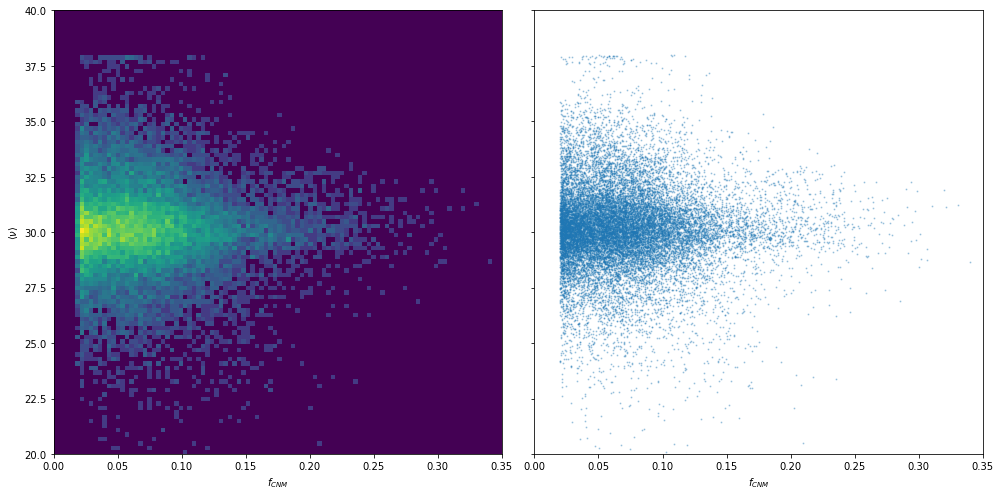

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(14,7), sharey=True)
ax[0].hist2d(fCNM, nu_avg, bins=100,range=[[0, .35], [20, 40]], norm=colors.PowerNorm(.4))
ax[0].set_ylabel(r'$\langle \nu \rangle$')
ax[0].set_xlabel(r'$f_{CNM}$')

ax[1].scatter(fCNM, nu_avg, s=1, alpha=.3)
ax[1].set_xlim(0, .35)
ax[1].set_ylim(20, 40)
ax[1].set_xlabel(r'$f_{CNM}$')

fig.tight_layout()